# Project: Quantifying the Performance of the Binomial Lattice Model


## Background
A binomial lattice model assumes that each discrete time increment, the state of the system, e.g., the share price of equity, the short rate, etc., can either increase by a factor $u$ with probability $p$ or decrease by a factor $d$ with probability $(1-p)$ in the next time interval. Thus, each discrete time interval can be modeled as a [Bernoulli random variable](https://en.wikipedia.org/wiki/Bernoulli_distribution):

<div>
    <center>
        <img src="figs/Fig-Binomial-Lattice-Schematic.png" width="280"/>
    </center>
</div>

Different models have been developed to compute the tuple $(u,d,p)$. However, for now, let's analyze historical data and learn typical values governing the price movement for each firm in the [S&P 500](https://en.wikipedia.org/wiki/S%26P_500).

## Learning Objectives
In this project, students will test the effectiveness of the binomial lattice model as a predictive approach for the short-term projection of equity share price. 

* __Objective__: Quantify the binomial lattice model prediction rate by comparing historical data for different periods and firms with lattice model predictions. Compute the probability of a `successful` prediction.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our example problem.

### Packages
The `Include.jl` file loads several packages that we use'll for our exercises:
* [Dates.jl](https://docs.julialang.org/en/v1/stdlib/Dates/#Dates)  is a package included with the standard library which provides basic functionality for working dates.
* [DataFrames.jl](https://dataframes.juliadata.org/stable/) and [CSV.jl](https://github.com/JuliaData/CSV.jl) provide a set of tools for working with tabular data in [Julia](https://julialang.org). Its design and functionality are similar to those of [Pandas (in Python)](https://pandas.pydata.org) and [data.frame, data.table and dplyr (in R)](https://dplyr.tidyverse.org), making it an excellent general-purpose data science tool.
* [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) is a [Julia](https://julialang.org) package for probability distributions and associated functions.
* [PrettyTables.jl](https://ronisbr.github.io/PrettyTables.jl/stable/man/html_backend/) is a [Julia](https://julialang.org) package that implements functions to construct and display text-based tables
* [Plots.jl](https://docs.juliaplots.org/stable/) is a plotting library, and [Colors.jl](https://github.com/JuliaGraphics/Colors.jl) is a color library that we'll use for data visualization in [Julia](https://julialang.org).
* [LinearAlgebra.jl](https://github.com/JuliaLang/LinearAlgebra.jl) is a package that provides functionality for working with linear algebra in [Julia](https://julialang.org).
* [Statistics.jl](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics) is a package included with the standard library module, which contains basic statistics functionality

### Types
`Include.jl` loads some [problem-specific types](https://docs.julialang.org/en/v1/manual/types/#Composite-Types) that will be helpful for the lattice model simulation of equity share prices:

The `MyBinomialEquityPriceTree` encodes the lattice model. The `MyBinomialEquityPriceTree` has several essential fields:
    
* The `connectivity::Union{Nothing, Dict{Int64, Array{Int64,1}}}` field holds the indexes of the children for each parent node of the tree.
* The `levels::Union{Nothing, Dict{Int64,Array{Int64,1}}}` field holds indexes of nodes that belong to each level of the tree, i.e., a particular trading day.
* The `u::Float64` field holds the value of the `up` factor
* The `d::Float64` field holds the value of the `down` factor
* The `p::Float64` field holds the value of the probability of an `up` move.
* The `data::Union{Nothing, Dict{Int64, MyBiomialLatticeEquityNodeModel}}` holds each node in the tree; nodes are of type `MyBiomialLatticeEquityNodeModel`


Each node in the tree is a `MyBiomialLatticeEquityNodeModel` type. The `MyBiomialLatticeEquityNodeModel` has two important fields:
* The `price::Float64` field holds the price value for a node
* The `probability::Float64` field holds the probability value associated with this node

### Functions
`Include.jl` loads the following [Julia functions](https://docs.julialang.org/en/v1/manual/functions/):

`function loaddatafile(; firm::Int = 1, year::String = "Year-1")::DataFrame -> DataFrame` 
 > This function, which load hostorical share price data, takes an [Int](https://docs.julialang.org/en/v1/manual/integers-and-floating-point-numbers/#Integers) that encodes a `firm index` and a [String](https://docs.julialang.org/en/v1/manual/strings/) arguement that holds the `year` parameter of the dataset. The historical share price data is returned to the caller as a [DataFrame](https://dataframes.juliadata.org/stable/) with the fields: `volume`,`volume_weighted_average_price`,`open`,`close`,`high`, and `low,number_of_transactions`.
 
`function analyze(R::Array{Float64,1};  Δt::Float64 = (1.0/365.0)) -> Tuple{Float64,Float64,Float64}`
> The `analyze(...)` function takes an array of return values in the `R` argument and a value of the time-step size of the simulation in the $\Delta{t}$ parameter (default value of 1-day) and returns estimated values for the lattice model parameters $(u,d,p)$.  
 
`function build(model::Type{MyBinomialEquityPriceTree}, data::NamedTuple) -> MyBinomialEquityPriceTree` 
> This function takes information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument (the $(u,d,p)$ values) and returns an instance of the `MyBinomialEquityPriceTree` [mutable type](https://docs.julialang.org/en/v1/manual/types/#Mutable-Composite-Types). Note: the `MyBinomialEquityPriceTree` returned from the `build(...)` function does not have price or probability information computed yet. To populate this data, call the `populate(...)` function.

`function populate(model::MyBinomialEquityPriceTree, Sₒ::Float64, h::Int) -> MyBinomialEquityPriceTree`
> The `populate(...)` function takes the `model::MyBinomialEquityPriceTree` instance returned from `build(...)`, a starting share price $S_{o}$ and the height of the tree, i.e., the number of time steps to simulate, and returns an updated `model::MyBinomialEquityPriceTree` instance with the price and probabilities computed for each node in the tree.

`function generate_firm_index_set() -> Set{Int64}`
> The `generate_firm_index_set()` function generates the set of `firm_id` values for which we have data files for all the years of this study, i.e., `Year-1,...,Year-5`. 

In [1]:
include("Include.jl");

  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-1`


## Prerequisite: Load the Binomial Lattice Model Parameters and Historical Dataset
We've computed the bionomal lattice parameters for each firm in the dataset using the `analyze(...)` function and stored these values in a text file. We load the lattice model parameters using the `loadmodelparametersfile()` function which returns a `DataFrame` of parameters, which we store in the `parameters` variable:

In [2]:
parameters = loadmodelparametersfile();

Next, we load the Open High Low Close (OHLC) data files for all firms for `Year-1 ... Year-5` using the `loaddatafile(...)` function. This function returns a `DataFrame` holding a year’s worth of data (approximately 252 records). Since we are loading multiple years of data for each firm, we combine all the annual `DataFrame` instances into a single `DataFrame` using the [DataFrame append! function](https://docs.juliahub.com/DataFrames/AR9oZ/0.21.5/lib/functions/#Base.append!). We store the combined `DataFrames` in the `dataset` dictionary where keys corresponding to the `firm_id`:

In [3]:
years = ["Year-1", "Year-2", "Year-3", "Year-4", "Year-5"];
number_of_firms = nrow(parameters);
dataset = Dict{Int64,DataFrame}();
for i ∈ 1:number_of_firms
    firm_index = parameters[i,:firm];
    for year ∈ years
        tmp_data = loaddatafile(firm=firm_index, year=year);
        
        if (haskey(dataset,firm_index) == false)
            dataset[firm_index] = tmp_data;
        else
            append!(dataset[firm_index], tmp_data)
        end
    end
end

### Clean the dataset: missing data
Not all the firms in the `dataset` have the maximum number of trading days, i.e., some firms are missing information for various reasons; perhaps they were acquired, merged, or were delisted, etc. We will exclude these firms from the `dataset`.

#### Implementation
First, we specify the `max_number_of_records` variable, which holds the number of trading records we expect for each firm, in this case, `1256`. Then, we iterate through all the firms in the `dataset` using a `for` loop. We remove those firms from the `dataset` whose row count (calculated by calling the `nrow(...)` function) is not equal to the `max_number_of_records`; a firm is removed from the `dataset` using the [delete! function](https://docs.julialang.org/en/v1/base/collections/#Base.delete!):

In [4]:
max_number_of_records = 1256
for i ∈ 1:number_of_firms
    firm_index = parameters[i,:firm];
    data = dataset[firm_index];
    
    if (nrow(data) != max_number_of_records)
        delete!(dataset, firm_index);
    end
end

Finally, now that we have removed firms with missing data from the `dataset`, we populate the variable `list_of_firm_ids` which holds a sorted array of `firm_id` values, and determine the number of firms in the `dataset` using the `length(...)` function, which we store in the `number_of_firms` variable:

In [5]:
list_of_firm_ids = keys(dataset) |> collect |> sort;
number_of_firms = length(list_of_firm_ids);

## Objective: Quantifying the Binomial Lattice Model Prediction Rate
Let's compute the probability of a correct prediction for the Binomial lattice model. To accomplish this, we randomly divide time into contiguous segments $\mathcal{I}_{k}\in\mathcal{I}$ of length `T` days. At the start of each interval $\mathcal{I}_{k}$, we will construct and populate a binomial lattice model using the `build(…)` and `populate(…)` functions. Then, we will compare the actual price of a firm denoted by $S_{j}$ at time $j$ with the simulated price during each time segment: 

* If the simulated price falls between a lower bound $L_{j}$ and an upper bound $U_{j}$ for all $j\in\mathcal{I}_{k}$, the simulation is considered a `success`. The lower $L_{j}$ and upper $U_{j}$ bounds can be specified. However, by default, they are set to $\mu\pm{2.576}\cdot\sigma$, where $\mu$ is the expected value and $\sigma$ is the standard deviation of the binomial lattice simulation.
* However, if the actual price violates either the lower or upper bound at any point, the simulation is deemed a `failure`.

First, specify the number of trading days in each interval in the `T` variable, and the length of each interval in the `Δt` variable:

In [6]:
T = 42;
Δt = (1.0/252.0);

Next, we partition time into random intervals $\mathcal{I}_{k}\in\mathcal{I}$. We define the `date_range_set`, which holds time intervals $\mathcal{I}_{k}$, and populate this set using a `while` loop. For each pass of the loop, we randomly generate a `start_index`, and then compute a `stop_index` by adding the number of trading days `T` to the `start_index`. We continue iterating until we have generated `number_of_date_ranges` in $\mathcal{I}$, i.e., $\dim\mathcal{I}=$`number_of_date_ranges`:

In [7]:
date_range_set = Set{StepRange{Int64, Int64}}();
number_of_date_ranges = 100;
counter = 0
while (counter < number_of_date_ranges)
    
    start_index = rand(1:(max_number_of_records - T - 1))
    stop_index = start_index + T
    range(start_index, stop=stop_index, step=1) |> (x-> push!(date_range_set, x))
    
    counter = length(date_range_set);
end

### Simulation
The hidden simulation code block evaluates every firm in the `dataset` for each time interval in the `date_range_set`. It populates two data structures: 

* The `success_simulation_set = Set{Tuple{Int64, StepRange{Int64, Int64}}}()` is the [Set](https://docs.julialang.org/en/v1/base/collections/#Base.Sethttps://docs.julialang.org/en/v1/base/collections/#Base.Set) that contains the `firm_id` and the time interval that has passed the bounds test encoded as a [Julia Tuple](https://docs.julialang.org/en/v1/manual/functions/#Tupleshttps://docs.julialang.org/en/v1/manual/functions/#Tuples).
* The `failed_simulation_set = Set{Tuple{Int64, StepRange{Int64, Int64}}}()` is the [Set](https://docs.julialang.org/en/v1/base/collections/#Base.Sethttps://docs.julialang.org/en/v1/base/collections/#Base.Set) that contains the `firm_id` and the time interval that has `failed` the bounds test encoded as a [Julia Tuple](https://docs.julialang.org/en/v1/manual/functions/#Tupleshttps://docs.julialang.org/en/v1/manual/functions/#Tuples)

In [8]:
success_simulation_set = Set{Tuple{Int64, StepRange{Int64, Int64}}}()
failed_simulation_set = Set{Tuple{Int64, StepRange{Int64, Int64}}}()
failed_simulation_set = Set{Tuple{Int64, StepRange{Int64, Int64}}}()
levels = [k for k ∈ 0:(T-1)]
for firm_id ∈ list_of_firm_ids
    
    # parameters -
    ū = parameters[parameters.firm .== firm_id, :up] |> first;
    d̄ = parameters[parameters.firm .== firm_id, :down] |> first;
    p̄ = parameters[parameters.firm .== firm_id, :probability] |> first;
    
    # data for this firm
    firm_data = dataset[firm_id];
    
    date_range_set_copy = deepcopy(date_range_set)
    while (isempty(date_range_set_copy) == false)
        
        date_range = pop!(date_range_set_copy);
        start_index = first(date_range)
        stop_index = last(date_range)
        
        # set the starting price
        Sₒ = firm_data[start_index, :volume_weighted_average_price];
        
        # build the model, populate with price estimates 
        model = build(MyBinomialEquityPriceTree, (
            u = ū, d = d̄, p = p̄)) |> (x-> populate(x, Sₒ, T));
        
        expectation = 𝔼(model, levels; startindex = start_index);
        variance = Var(model, levels; startindex = start_index);
        
        L = expectation[:,2] .- 2.576*sqrt.(variance[:,2])
        U = expectation[:,2] .+ 2.576*sqrt.(variance[:,2])
        
        # check the bounds: if below L, or above U then simulation failed
        success_flag = true;
        for k ∈ 1:T
            if (firm_data[start_index+k-1,:volume_weighted_average_price] < L[k]) || (firm_data[start_index+k-1,:volume_weighted_average_price] > U[k])
                success_flag  = false;
                break;
            end
        end
        
        position_tuple = (firm_id, date_range)
        if (success_flag == true)
            push!(success_simulation_set, position_tuple);
        else
            push!(failed_simulation_set, position_tuple);
        end
    end
end

#### Visualize a random `successful` simulation:

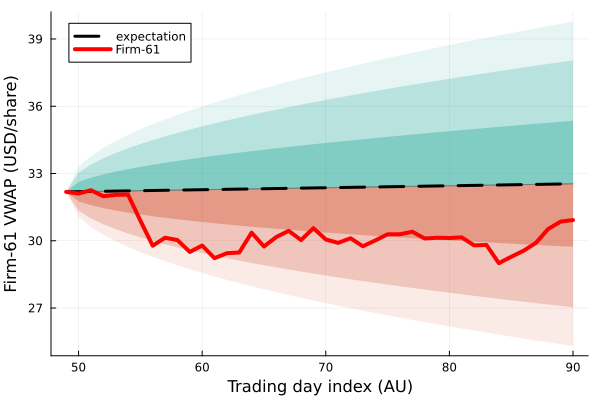

In [9]:
begin
    result_tuple_success = rand(success_simulation_set)
    firm_id_success = result_tuple_success |> first;
    firm_data_success = dataset[firm_id_success];

    date_range = result_tuple_success |> last;
    start_index = first(date_range)
    stop_index = last(date_range)
    Sₒ = firm_data_success[start_index, :volume_weighted_average_price];

    # parameters -
    ū = parameters[parameters.firm .== firm_id_success, :up] |> first;
    d̄ = parameters[parameters.firm .== firm_id_success, :down] |> first;
    p̄ = parameters[parameters.firm .== firm_id_success, :probability] |> first;

    # build the model, populate with price estimates 
    model = build(MyBinomialEquityPriceTree, (
        u = ū, d = d̄, p = p̄)) |> (x-> populate(x, Sₒ, T));

    expectation = 𝔼(model, levels; startindex = start_index);
    variance = Var(model, levels; startindex = start_index);

    L68 = expectation[:,2] .- sqrt.(variance[:,2])
    U68 = expectation[:,2] .+ sqrt.(variance[:,2])
    L95 = expectation[:,2] .- 1.96*sqrt.(variance[:,2])
    U95 = expectation[:,2] .+ 1.96*sqrt.(variance[:,2])
    L99 = expectation[:,2] .- 2.576*sqrt.(variance[:,2])
    U99 = expectation[:,2] .+ 2.576*sqrt.(variance[:,2])

    plot(expectation[:,1], expectation[:,2], fillrange=L68, c=colors[5], alpha=0.3, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=U68, c=colors[6], alpha=0.3, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=L95, c=colors[5], alpha=0.2, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=U95, c=colors[6], alpha=0.2, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=L99, c=colors[5], alpha=0.1, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=U99, c=colors[6], alpha=0.1, label="")
    plot!(expectation[:,1], expectation[:,2],c=:black, lw=3,ls=:dash, label="expectation")
    plot!(levels .+ start_index, firm_data_success[levels .+ start_index, :volume_weighted_average_price],  
        lw=4, c=:red, label="Firm-$(firm_id_success)", legend = :topleft)

    xlabel!("Trading day index (AU)", fontsize=18)
    ylabel!("Firm-$(firm_id_success) VWAP (USD/share)", fontsize=18)
end

#### Visualize a random `failed` simulation:

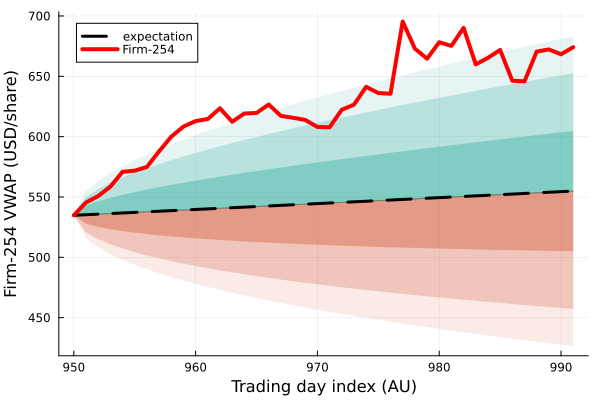

In [10]:
begin
    
    result_tuple_failed = rand(failed_simulation_set)
    firm_id_failed = result_tuple_failed |> first;
    firm_data_failed = dataset[firm_id_failed];

    date_range = result_tuple_failed |> last;
    start_index = first(date_range)
    stop_index = last(date_range)

    Sₒ = firm_data_failed[start_index, :volume_weighted_average_price];

    # parameters -
    ū = parameters[parameters.firm .== firm_id_failed, :up] |> first;
    d̄ = parameters[parameters.firm .== firm_id_failed, :down] |> first;
    p̄ = parameters[parameters.firm .== firm_id_failed, :probability] |> first;

    # build the model, populate with price estimates 
    model = build(MyBinomialEquityPriceTree, (
        u = ū, d = d̄, p = p̄)) |> (x-> populate(x, Sₒ, T));

    expectation = 𝔼(model, levels; startindex = start_index);
    variance = Var(model, levels; startindex = start_index);

    L68 = expectation[:,2] .- sqrt.(variance[:,2])
    U68 = expectation[:,2] .+ sqrt.(variance[:,2])
    L95 = expectation[:,2] .- 1.96*sqrt.(variance[:,2])
    U95 = expectation[:,2] .+ 1.96*sqrt.(variance[:,2])
    L99 = expectation[:,2] .- 2.576*sqrt.(variance[:,2])
    U99 = expectation[:,2] .+ 2.576*sqrt.(variance[:,2])

    plot(expectation[:,1], expectation[:,2], fillrange=L68, c=colors[5], alpha=0.3, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=U68, c=colors[6], alpha=0.3, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=L95, c=colors[5], alpha=0.2, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=U95, c=colors[6], alpha=0.2, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=L99, c=colors[5], alpha=0.1, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=U99, c=colors[6], alpha=0.1, label="")
    plot!(expectation[:,1], expectation[:,2],c=:black, lw=3,ls=:dash, label="expectation")
    plot!(levels .+ start_index, firm_data_failed[levels .+ start_index, :volume_weighted_average_price],  
        lw=4, c=:red, label="Firm-$(firm_id_failed)", legend = :topleft)

    xlabel!("Trading day index (AU)", fontsize=18)
    ylabel!("Firm-$(firm_id_failed) VWAP (USD/share)", fontsize=18)
end

### Compute the probability of success $p_{+}$ for each firm
To determine the likelihood of the lattice model succeeding on a random time interval, we examine the `successful_simulation_set` and estimate the probability that the GBM model can successfully predict equity prices in a random time interval. Store the probability of `success` in the `probability_dictionary` where the `keys` of the dictionary are the `firm_id` values and the `values` are the probability of a successful prection $p_{+}$: 

In [11]:
probability_dictionary = Dict{Int64, Float64}()
for success_case ∈ success_simulation_set
    
    firm_id = success_case |> first;
    if (haskey(probability_dictionary, firm_id) == false)
        probability_dictionary[firm_id] = (1/number_of_date_ranges);
    else
        probability_dictionary[firm_id] += (1.0/number_of_date_ranges);
    end
end

In [12]:
probability_dictionary

Dict{Int64, Float64} with 458 entries:
  56  => 0.58
  35  => 0.63
  429 => 0.67
  425 => 0.73
  308 => 0.75
  67  => 0.6
  215 => 0.72
  319 => 0.65
  251 => 0.71
  112 => 0.6
  348 => 0.67
  185 => 0.67
  420 => 0.64
  404 => 0.69
  365 => 0.65
  417 => 0.74
  333 => 0.66
  86  => 0.76
  168 => 0.67
  431 => 0.72
  422 => 0.69
  263 => 0.73
  207 => 0.66
  242 => 0.69
  183 => 0.7
  ⋮   => ⋮

#### List the best and worst predicted firms
Select the number of firms to view, store this number in the variable `N`:

In [34]:
N = 10;

Next, let's transform the `probability_dictionary` into an array `A` so we can use the [sortperm function](https://docs.julialang.org/en/v1/base/sort/#Base.sortperm) which return a permutation vector `I` that puts the array `A[I]` in sorted order along the given dimension:

In [60]:
A = Array{Float64,2}(undef, number_of_firms, 2)
counter = 1
for (firm_id, probability) ∈ probability_dictionary
    A[counter,1] = 1.0*firm_id
    A[counter,2] = probability
    counter += 1
end
idx_sort = sortperm(A[:,2]);

##### Setup and poplulate the N-best firm table

In [69]:
best_table_data = Array{Any,2}(undef, N, 3)
best_table_header = (["Rank", "Firm index", "Probability"])
counter = 1
for i ∈ number_of_firms:-1:(number_of_firms-N+1)
    sort_index = idx_sort[i];
        
    best_table_data[counter,1] = counter;
    best_table_data[counter,2] = A[sort_index,1] |> Int
    best_table_data[counter,3] = A[sort_index,2]
    
    counter += 1
end
pretty_table(best_table_data, tf=tf_html_default, header=best_table_header)

Rank,Firm index,Probability
1,294,0.84
2,139,0.83
3,352,0.82
4,235,0.81
5,312,0.81
6,273,0.81
7,419,0.81
8,274,0.81
9,393,0.81
10,427,0.81


##### Setup and poplulate the N-worst firm table

In [70]:
worst_table_data = Array{Any,2}(undef, N, 3)
worst_table_header = (["Rank", "Firm index", "Probability"])
counter = 1
for i ∈ 1:N
    sort_index = idx_sort[i];
        
    worst_table_data[counter,1] = counter;
    worst_table_data[counter,2] = A[sort_index,1] |> Int
    worst_table_data[counter,3] = A[sort_index,2]
    
    counter += 1
end
pretty_table(worst_table_data, tf=tf_html_default, header=worst_table_header)

Rank,Firm index,Probability
1,170,0.52
2,432,0.52
3,165,0.52
4,276,0.54
5,368,0.54
6,345,0.55
7,153,0.55
8,68,0.56
9,145,0.56
10,108,0.56
